In [2]:
#import libraries
import numpy as np
import pandas as pd
import networkx as nx
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform

In [3]:
%matplotlib inline
import seaborn
plt.style.use('seaborn')#switch to seaborn style# TODO
seaborn.set_style(style='white')

In [5]:
tracks = pd.read_csv('data/tracks.csv', index_col=0, header=[0, 1]);

features_full= pd.read_csv('data/features.csv', index_col=0, header=[0, 1, 2])

genres=pd.read_csv('data/genres.csv', index_col=0, header=[0])

In [567]:
# normalize features
dfmax=abs(features_full).max()
dfmax[dfmax == 0] = 1
features=features_full.divide(dfmax)

In [814]:
# Keep only the genre for each track
label=pd.DataFrame({('label','genre','main'): tracks['track']['genre_top'],
                    ('label','genre','sub'): tracks['track']['genres']})

# Keep on the tracks from small subset
label = label[tracks['set','subset'] == 'small']


# Keep only the genres we want
genre_list = ['Rock','Folk','Hip-Hop']#[ 'Pop','Instrumental', 'International' 'Experimental''Electronic',]
label = label[label['label']['genre']['main'].isin(genre_list)]

#add sub genres
genres_dict=genres['title'].to_dict()
genres_dict={str(key):genres_dict[key] for key in genres_dict}

label['label']['genre']['sub']=label['label']['genre']['sub'].str.replace('[^0-9| ]','').str.split(' ').apply(lambda x:'|'.join([genres_dict[k] for k in x ]))


# Merging
dataSet = features.merge(label, left_index=True, right_on='track_id')
#dataSet=dataSet.sort_values([('label', 'genre','main')])


In [815]:
print(sum(dataSet.label.genre.main=='Rock'))
label.label.genre.main.unique()

1000


array(['Hip-Hop', 'Folk', 'Rock'], dtype=object)

In [816]:
#we calculate the distances of our dataset
distances = pdist(dataSet.drop(columns='label',level=0).values, metric='euclidean')
distances

array([1.70295279, 2.51859565, 2.68194901, ..., 3.22898428, 2.29360557,
       2.92122633])

In [817]:
#We calculate the weights of our adjacency matrix
kernel_width = distances.mean()
weights = np.exp(-distances**2 / kernel_width**2)
adjacency_full = squareform(weights)


In [818]:
# np.save("data/adjacency_HRJC.npy",adjacency_full)

In [819]:
# adjacency_full=np.load("data/adjacency_HRJC.npy")

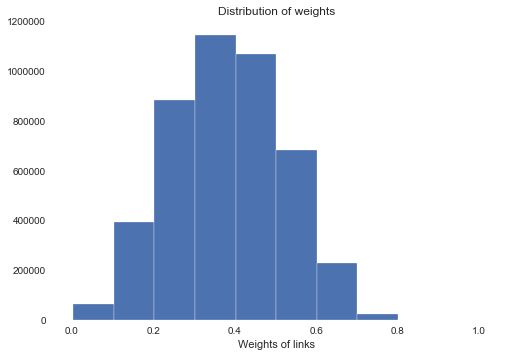

In [820]:
plt.hist(weights)
plt.title('Distribution of weights')
plt.xlabel('Weights of links')
plt.show()

In [821]:
#informatons over connectivity of main component 
adjacency=adjacency_full.copy() #we keep the original adjacency matrix
adjacency[adjacency < 0.65] = 0
graph=nx.from_numpy_matrix(adjacency)
print("#nodes= ",adjacency.shape[0])
print("#compo= ",nx.number_connected_components(graph))
list_comp=sorted(nx.connected_components(graph), key = len, reverse=True)
print("#nodes in giant component= ", len(list_comp[0]))
print("percentage of nodes in main component= ",len(list_comp[0])/adjacency.shape[0])

#nodes=  3000
#compo=  465
#nodes in giant component=  2512
percentage of nodes in main component=  0.8373333333333334


In [822]:
#list(nx.connected_component_subgraphs(graph))[1].node

In [823]:
#keep only the main component and corresponding label
conn_graph = list(nx.connected_component_subgraphs(graph))[0]
conn_label=label.iloc[list(list_comp[0])]

## Graph plot##

In [824]:
laplacian=nx.laplacian_matrix(conn_graph)

In [825]:
# conn_label.label.genre['sub'].str.split("|",expand=True).iloc[:,0]

In [826]:
# conn_label.label.genre['sub'].str.split("|",expand=True).iloc[:,0].unique()

In [827]:



# for i,name in enumerate( conn_label.label.genre['sub'].str.split("|",expand=True).stack().value_counts().to_frame(name='count').reset_index()['index']):
#     label_num[label_num==name]=5*i
#     print(name," ",5*i)
# label_num[label_num>10]=0   
# conn_label.label.genre['sub'].str.split("|",expand=True).iloc[:,0]

In [828]:
label2=np.array(conn_label.label.genre.main)
# label2=np.array(conn_label.label.genre['sub'].str.split("|",expand=True).iloc[:,0]);
label_num=label2.copy()

for i,name in enumerate( conn_label.label.genre.main.unique()):
    label_num[label_num==name]=i
    print(name," ",i)
    
# label_num[label_num=='Rock']=0
# label_num[label_num=='Hip-Hop']=1
# label_num[label_num=='Folk']=4
# label_num[label_num=='Pop']=3
# label_num[label_num=='Experimental']=4
# label_num[label_num=='Electronic']=5
# label_num[label_num=='International']=6
# label_num[label_num=='Instrumental']=7

print(label_num)

Hip-Hop   0
Folk   1
Rock   2
[0 0 1 ... 0 1 0]


In [829]:
e,eigenvectors = scipy.sparse.linalg.eigs(laplacian,k=6)

e=e.real
eigenvectors=eigenvectors.real
len(eigenvectors)

2512

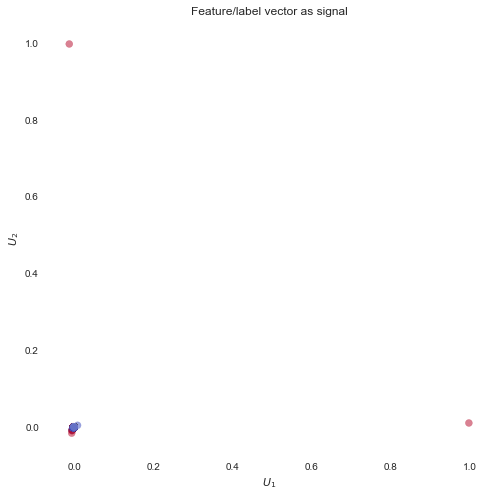

In [830]:
#using laplacian eigenmap
plt.figure(figsize=(8, 8))

plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], alpha=0.5, c=label_num, cmap='coolwarm')
plt.title('Feature/label vector as signal')
plt.xlabel('$U_1$')
plt.ylabel('$U_2$')
plt.show()

In [831]:
#using springlayout
coords = nx.spring_layout(conn_graph)  # Force-directed layout.

In [832]:
i=0
coords_x=[]
coords_y=[]
for i in (conn_graph.node):
    coords_x.append(coords[i][0])
    coords_y.append(coords[i][1]);   
    i+=1;
    

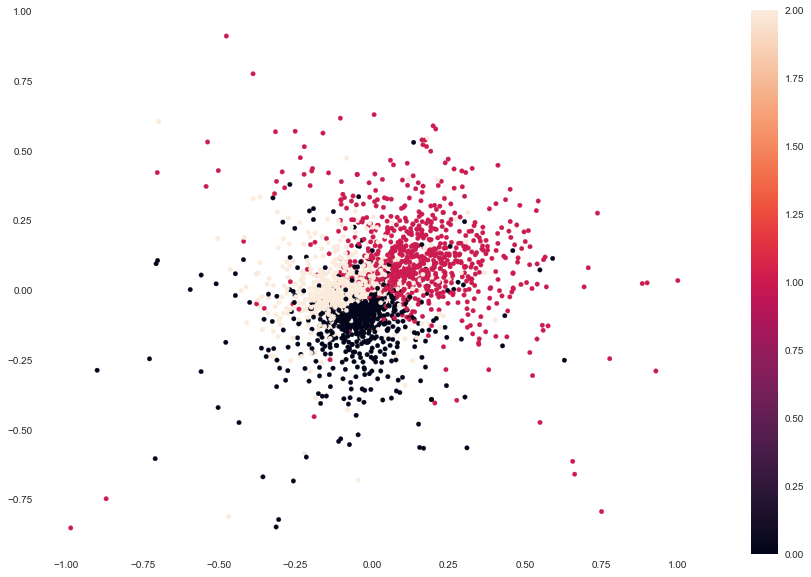

In [833]:
plt.figure(figsize=(15, 10))
nx.draw_networkx_nodes(conn_graph, coords,node_size=20, node_color=label_num)
# nx.draw_networkx_edges(conn_graph, coords, alpha=0.3)
sm = plt.cm.ScalarMappable( norm=plt.Normalize(vmin=np.min(label_num), vmax=np.max(label_num)))
sm._A = []
plt.colorbar(sm)
plt.show()

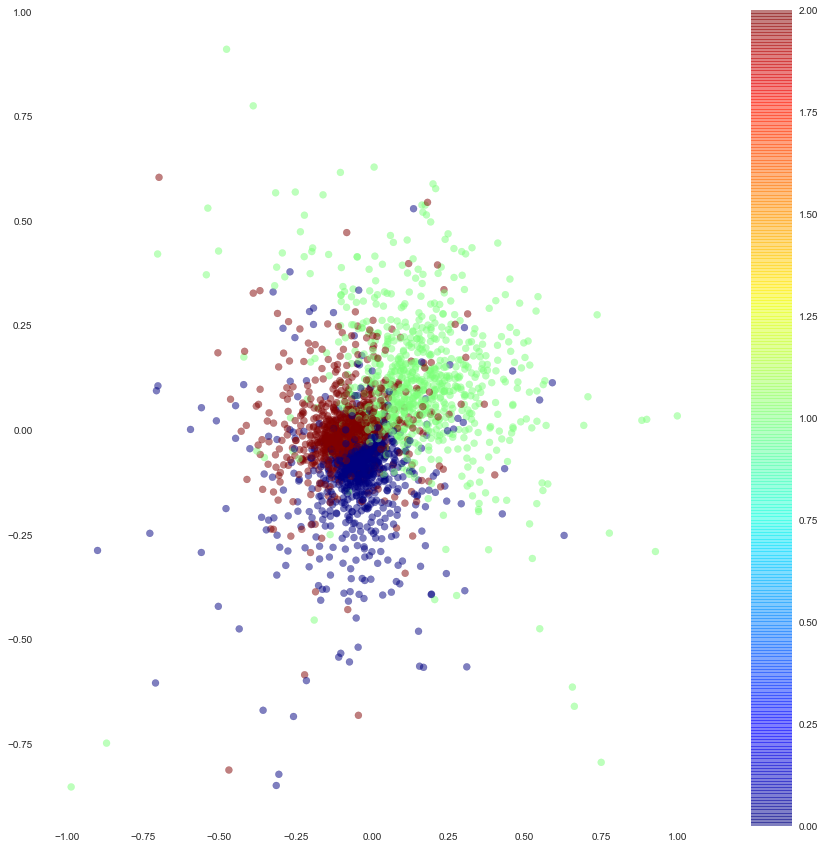

In [834]:
plt.figure(figsize=(15, 15))

plt.scatter(coords_x,coords_y,c=label_num , alpha=0.5, cmap='jet')

plt.colorbar()
plt.show()

In [835]:
tmp_label=list(np.array(conn_label.label.genre.main))

i=0;
node_dict=dict()
for n in conn_graph.node:
    node_dict[n]=i
    i+=1;
conn_graph_rename=nx.relabel_nodes(conn_graph,node_dict)

label_dict={i : tmp_label[i] for i in range(len(conn_graph.node))}
    
nx.set_node_attributes(conn_graph_rename, values=label_dict, name="genre")

In [813]:
# import random
# subnode=random.sample(list(conn_graph.node), 5000)
# sub_graph=conn_graph.subgraph(subnode)
nx.write_gexf(conn_graph_rename, "data/graph_small_HRFP.gexf")

In [608]:
# conn_graph_rename.node

# personal tests

In [609]:
dataSet

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             0.000812  0.001826  0.000140  0.000317  0.000465  0.000189   
5             0.000060 -0.000027 -0.000157  0.000161  0.000608  0.000313   
140           0.000060 -0.000218 -0.000611 -0.000254 -0.000240 -0.000026   
141           0.000020 -0.000099 -0.000658 -0.000250 -0.000222 -0.000252   
182           0.000034  0.000376 -0.000262  0.000034 -0.000098  0.000406   
190          -0.000037 -0.000297 -0.000467 -0.000190 -0.000369 -0.000236   
193          -0.000035 -0.000368 -0.000058 -0.000150 -0.000254 -0.000218   
194          -0.000091 -0.000051 -0.000632 -0.000244 -0.000387 -0.000356   
197          -0.000120 -0.000399 -0.000065 -0.000264 -0.000250 -0.000289   
200          -0.000138  0.000302 -0.000791  0.000561 -0.000487 -0.000206   
203          -0.000087 -0.000419 -0.000421 -0.000151 -0.000261 -0.000339   
204          -0.000108 -0.000045 -0.000239 -0.000112 -0.000136 -0.000086   
207          -0.000133 -0.000260 -0.000134 -0.000284 -0.000389 -0.000297   
210          -0.000129 -0.000267 -0.000224 -0.000205  0.000094 -0.000189   
211          -0.000038 -0.000071 -0.000122 -0.000018  0.000173 -0.000227   
212           0.000161 -0.000255 -0.000503 -0.000211  0.000409 -0.000208   
255           0.000013  0.000364  0.000096  0.000028  0.000108  0.000030   
256           0.000005  0.001845 -0.000196 -0.000051 -0.000174 -0.000115   
368           0.000139  0.000492  0.000064  0.000916  0.001274  0.001085   
459           0.000175 -0.000357 -0.000213 -0.000146 -0.000291 -0.000325   
534          -0.000041 -0.000256  0.000245  0.000020  0.000511 -0.000105   
540           0.000033 -0.000060  0.000166  0.000041  0.000218  0.000252   
546           0.000017  0.000145 -0.000043 -0.000051  0.000210  0.000175   
574           0.000027  0.000253  0.000657 -0.000092  0.001066  0.000076   
602          -0.000056 -0.000238 -0.000690 -0.000230 -0.000275 -0.000161   
620           0.000029 -0.000048 -0.000585  0.000023 -0.000263 -0.000250   
621          -0.000101 -0.000321  0.000709  0.000091  0.000140  0.000067   
625           0.000007  0.000048  0.000171 -0.000161 -0.000361 -0.000395   
676          -0.000010 -0.000423 -0.000265 -0.000107 -0.000287  0.000042   
690          -0.000003  0.000294  0.001029  0.000419  0.000700  0.000171   
...                ...       ...       ...       ...       ...       ...   
149370        0.000035  0.000166 -0.000660  0.000237  0.000167 -0.000411   
149416        0.000087 -0.000498 -0.000684 -0.000276  0.000168 -0.000017   
149417        0.000069 -0.000304 -0.000087 -0.000172  0.000260  0.000931   
149452        0.000075 -0.000253 -0.000138  0.000264 -0.000065 -0.000023   
149488       -0.000087  0.000096  0.000677  0.000069 -0.000368 -0.000375   
149523       -0.000032 -0.000167  0.000284 -0.000303 -0.000220 -0.000352   
149623       -0.000028  0.000158 -0.000123 -0.000138 -0.000051  0.000008   
149625       -0.000056 -0.000062 -0.000036  0.000053  0.000070  0.000350   
149626        0.000016 -0.000101  0.000195  0.000033  0.000073 -0.000015   
149687        0.000040 -0.000234 -0.000211 -0.000104 -0.000278 -0.000140   
149689       -0.000032 -0.000188  0.000203  0.000207  0.000326  0.000188   
149690        0.000153  0.000469  0.000392  0.000189  0.000040  0.000121   
149951        0.000148  0.000336 -0.000193  0.000172  0.000077  0.000036   
149953       -0.000009  0.000436  0.001017  0.000364  0.000785  0.000536   
150062       -0.000094 -0.000284 -0.000436  0.000257 -0.000107  0.000031   
150063       -0.000099 -0.000239 -0.000448 -0.000094 -0.000138 -0.000158   
150064       -0.000088 -0.000253 -0.000297 -0.000201 -0.000216 -0.000390   
150287       -0.000059  0.000066  0.000254  0.00

In [610]:
genre_top=genres[genres['parent']==0]
genre_top

,#tracks,parent,title,top_level
genre_id,,,,
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5
8,868,0,Old-Time / Historic,8
9,1987,0,Country,9
10,13845,0,Pop,10
12,32923,0,Rock,12
13,730,0,Easy Listening,13


In [611]:
tracks_raw = pd.read_csv('../data/fma_metadata/raw_tracks.csv', index_col=0);
tracks_raw['track_url'][2]

'http://freemusicarchive.org/music/AWOL/AWOL_-_A_Way_Of_Life/Food'

In [612]:
# find specific sample
samples=tracks[tracks['track']['genres']=='[15]']
samples_in_small=samples[samples['set']['subset'] == 'medium']
samples_in_small

album                                            \
         comments         date_created        date_released   
track_id                                                      
397             0  2009-01-07 11:04:01  2007-01-01 00:00:00   
398             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
399             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
400             0  2009-01-07 11:04:01  2007-01-01 00:00:00   
405             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
414             0  2008-11-26 02:01:54  2005-07-05 00:00:00   
550             0  2008-11-26 02:08:19  2009-01-08 00:00:00   
664             0  2008-11-26 02:14:23  2002-10-01 00:00:00   
665             0  2009-01-08 12:05:17  2009-01-08 00:00:00   
878             0  2008-11-26 02:25:39  2009-01-08 00:00:00   
881             0  2008-11-26 02:25:52  2009-01-12 00:00:00   
889             0  2008-11-26 02:25:39  2009-01-08 00:00:00   
1085            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1086            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1088            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1089            0  2008-11-26 02:34:28  2003-01-20 00:00:00   
1121            0  2008-11-26 02:38:27  2009-01-14 00:00:00   
1339            0  2008-11-26 02:48:07  1995-01-01 00:00:00   
1481            0  2008-11-26 02:58:25  2007-01-01 00:00:00   
1483            0  2008-11-26 02:58:25  2007-01-01 00:00:00   
1485            0  2008-11-26 02:58:25  2007-01-01 00:00:00   
1486            0  2008-11-26 02:58:24  2009-01-16 00:00:00   
1634            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1635            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1638            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1640            0  2008-11-26 03:06:22  2006-01-01 00:00:00   
1677            0  2008-11-26 03:07:47  2009-01-23 00:00:00   
1678            0  2008-11-26 03:07:47  2009-01-23 00:00:00   
3268            0  2008-12-04 09:27:11  2008-09-29 00:00:00   
3452            0  2008-12-04 09:27:17  2008-10-14 00:00:00   
...           ...                  ...                  ...   
145800          0  2016-11-03 15:38:21                  NaN   
145801          0  2016-11-03 15:38:21                  NaN   
145802          0  2016-11-03 15:38:21                  NaN   
145803          0  2016-11-03 15:38:21                  NaN   
145804          0  2016-11-03 15:38:21                  NaN   
145805          0  2016-11-03 15:38:21                  NaN   
147919          0  2016-12-16 17:21:41                  NaN   
147920          0  2016-12-16 17:21:41                  NaN   
147921          0  2016-12-16 17:21:41                  NaN   
147922          0  2016-12-16 17:21:41                  NaN   
147923          0  2016-12-16 17:21:41                  NaN   
147924          0  2016-12-16 17:21:41                  NaN   
148960          0  2017-01-05 17:21:03  2017-01-06 00:00:00   
148961          0  2017-01-05 17:21:03  2017-01-06 00:00:00   
148962          0  2017-01-05 17:21:03  2017-01-06 00:00:00   
151026          0  2017-02-06 14:47:39  2016-06-11 00:00:00   
151654          0  2017-02-09 16:56:41  2013-08-09 00:00:00   
152317          0  2017-02-13 15:07:42  2011-09-16 00:00:00   
152318          0  2017-02-13 15:07:42  2011-09-16 00:00:00   
152319          0  2017-02-13 15:07:42  2011-09-16 00:00:00   
152322          0  2017-02-13 15:24:45  2011-11-04 00:00:00   
152323          0  2017-02-13 15:24:45  2011-11-04 00:00:00   
152546          0  2017-02-15 14:56:34                  NaN   
152550          0  2017-02-15 14:56:34                  NaN   
152552          0  2017-02-15 14:56:34                  NaN   
152553          0  2017-02-15 14:56:34                  NaN   
152554          0  2017-02-15 14:56:34                  NaN   
152704          0  2017-02-17 23:53:05  2005-10-16 00:00:00   
152720          0  2017-02-18 00:07:12  2007-12-27 00:00:00   
152721          0  2017-02-18 00:07:12  200

In [613]:
label['label']['genre']['main'].unique()

array(['Hip-Hop', 'Folk', 'Rock'], dtype=object)